# Predict Interaction Point in Graphs with Edges

#### Features:
  - Graph : Number of Tracks
  - Node  : $[x, y, z] + [0, 0, 1, 0, 0, 0]$ i.e. coordinate + layers
  - Edge  : $[dist, u_x, u_y, u_z, v_x, v_y, v_z, layer_u, layer_v]$ i.e. distance + start_coordinate + end_coordinate + start_layers + end_layers

#### Labels:
  - Graph : $[x,y,z]$ i.e. the interaction point

In [1]:
PATH_PREFIX = '../'
DATA_DIR = 'D0toPiKInAcceptanceSignal_Iteration1_Parsed/'
MODEL_SAVE_DIR = 'Model(Interaction Point)/'
DATA_FILE_PATH = PATH_PREFIX + DATA_DIR + 'dataset_{:04d}.json'

In [2]:
#@title Imports

import sys
sys.path.append(PATH_PREFIX)

from __future__ import absolute_import, division, print_function

from graphGenerator import to_graph_dict_with_interaction_point

import collections
import ujson
import time, math

from graph_nets import utils_np, utils_tf
import modelTrack as model

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf

In [3]:
#@title Helper functions


def get_node_pos(graph):
    return {
        k: np.array([v['features'][0], v['features'][1]])
        for k, v in graph.node.items()
    }


def generate_dict_graphs(raw_data, offset, batch_size):
    """Generate graphs for training.
    
    Args:
        raw_data: The list of raw data objects.
        offset: Starting index to pick from the `raw_data`.
        batch_size: Total number of graphs per batch.
        
    Returns:
        input_graph_dict: An input graph in dictionary format.
        target_graph_dict: A labelled input graph in dictionary format.
    """
    input_graphs, target_graphs = [], []
    for i in range(offset, offset + batch_size):
        input_graph_dict, target_graph_dict = to_graph_dict_with_interaction_point(
            raw_data[i])
        input_graphs.append(input_graph_dict)
        target_graphs.append(target_graph_dict)
    return input_graphs, target_graphs


def create_placeholders(raw_data, offset, batch_size):
    """Creates placeholders for the model training and evaluation.

  Args:
    raw_data: The list of raw data objects.
    offset: Starting index to pick from the `raw_data`.
    batch_size: Total number of graphs per batch.

  Returns:
    input_ph: The input graph's placeholders, as a graph namedtuple.
    target_ph: The target graph's placeholders, as a graph namedtuple.
  """
    # Create some example data for inspecting the vector sizes.
    input_graphs, target_graphs = generate_dict_graphs(raw_data, offset,
                                                       batch_size)
    input_ph = utils_tf.placeholders_from_data_dicts(input_graphs)
    target_ph = utils_tf.placeholders_from_data_dicts(target_graphs)

    return input_ph, target_ph


def create_feed_dict(raw_data, offset, batch_size, input_ph, target_ph):
    """Creates placeholders for the model training and evaluation.

  Args:
    raw_data: The list of raw data objects.
    offset: Starting index to pick from the `raw_data`.
    batch_size: Total number of graphs per batch.
    input_ph: The input graph's placeholders, as a graph namedtuple.
    target_ph: The target graph's placeholders, as a graph namedtuple.

  Returns:
    feed_dict: The feed `dict` of input and target placeholders and data.
  """
    inputs, targets = generate_dict_graphs(raw_data, offset, batch_size)
    input_graphs = utils_np.data_dicts_to_graphs_tuple(inputs)
    target_graphs = utils_np.data_dicts_to_graphs_tuple(targets)
    feed_dict = {input_ph: input_graphs, target_ph: target_graphs}

    return feed_dict


def compute_accuracy(target, output):
    tdds = utils_np.graphs_tuple_to_data_dicts(target)
    odds = utils_np.graphs_tuple_to_data_dicts(output)
    distances = []
    
    
#     t, o = tdds[0]["globals"], odds[0]["globals"]
#     print(t)
#     print(o)
#     print(math.sqrt((t[0] - o[0])**2 + (t[1] - o[1])**2 +
#                           (t[2] - o[2])**2))
                
                
    for td, od in zip(tdds, odds):
        t, o = td['globals'], od['globals']
        error = math.sqrt((t[0] - o[0])**2 + (t[1] - o[1])**2 +
                          (t[2] - o[2])**2)
        distances.append(error)
    mean_error = np.mean(distances)
    return mean_error


def create_loss_ops(target_op, output_ops):
    loss_ops = [
        tf.losses.mean_squared_error(target_op.globals, output_op.globals)
        for output_op in output_ops
    ]
    return loss_ops


def make_all_runnable_in_session(*args):
    """Lets an iterable of TF graphs be output from a session as NP graphs."""
    return [utils_tf.make_runnable_in_session(a) for a in args]


class GraphPlotter(object):
    def __init__(self, graph, pos, style={}):
        self._graph = graph
        self._pos = pos
        self._base_draw_kwargs = dict(G=self._graph, pos=self._pos)
        self._nodes = None
        self._edges = None

    @property
    def nodes(self):
        if self._nodes is None:
            self._nodes = self._graph.nodes()
        return self._nodes

    @property
    def edges(self):
        if self._edges is None:
            self._edges = self._graph.edges()
        return self._edges

    def _make_draw_kwargs(self, **kwargs):
        kwargs.update(self._base_draw_kwargs)
        return kwargs

    def _draw(self, draw_function, zorder=None, **kwargs):
        draw_kwargs = self._make_draw_kwargs(**kwargs)
        collection = draw_function(**draw_kwargs)
        if collection is not None and zorder is not None:
            try:
                # This is for compatibility with older matplotlib.
                collection.set_zorder(zorder)
            except AttributeError:
                # This is for compatibility with newer matplotlib.
                collection[0].set_zorder(zorder)
        return collection

    def draw_nodes(self, **kwargs):
        """Useful kwargs: nodelist, node_size, node_color, linewidths."""
        if ("node_color" in kwargs
                and isinstance(kwargs["node_color"], collections.Sequence)
                and len(kwargs["node_color"]) in {3, 4}
                and not isinstance(kwargs["node_color"][0],
                                   (collections.Sequence, np.ndarray))):
            num_nodes = len(kwargs.get("nodelist", self.nodes))
            kwargs["node_color"] = np.tile(
                np.array(kwargs["node_color"])[None], [num_nodes, 1])
        return self._draw(nx.draw_networkx_nodes, **kwargs)

    def draw_edges(self, **kwargs):
        """Useful kwargs: edgelist, width."""
        return self._draw(nx.draw_networkx_edges, **kwargs)

    def draw_graph(self,
                   node_size=10,
                   node_color=(1.0, 1.0, 1.0),
                   edge_width=0.2,
                   edge_color='blue',
                   draw_edge_arrow=False,
                   edge_style='dotted',
                   node_linewidth=0.2):
        node_border_color = (0.0, 0.0, 0.0, 1.0)
        if isinstance(node_color, dict):
            c = [node_color[n] for n in self.nodes]
        else:
            c = node_color
        # Plot nodes.
        self.draw_nodes(nodelist=self.nodes,
                        node_size=node_size,
                        node_color=c,
                        linewidths=node_linewidth,
                        edgecolors=node_border_color,
                        zorder=20)

        # Plot edges.
        self.draw_edges(edgelist=self.edges,
                        style=edge_style,
                        arrows=draw_edge_arrow,
                        width=edge_width,
                        edge_color=edge_color,
                        zorder=10)

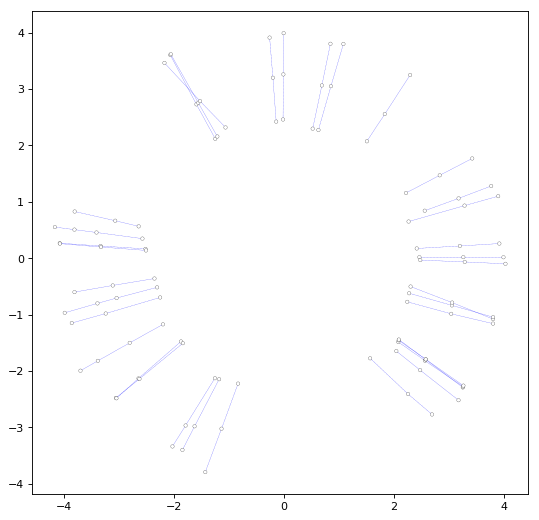

In [4]:
#@title Visualize example graphs

DATA_FILE_NUMBER = 1
DATA_POINT = 4  # [1 - 100]
SCALE = 2

data_file = open(DATA_FILE_PATH.format(DATA_FILE_NUMBER), 'r')
input_raw_data = ujson.loads(data_file.read())
data_file.close()

input_ph, target_ph = create_placeholders(input_raw_data, DATA_POINT - 1, 1)
feed_dict = create_feed_dict(input_raw_data, DATA_POINT - 1, 1, input_ph,
                             target_ph)
input_graphs_tuple, target_graphs_tuple = feed_dict[input_ph], feed_dict[
    target_ph]

# We can visualize the graph using networkx.
input_graphs_nx = utils_np.graphs_tuple_to_networkxs(input_graphs_tuple)[0]
target_graphs_nx = utils_np.graphs_tuple_to_networkxs(target_graphs_tuple)[0]

# print('====================================')

# print(input_graphs_nx.graph)
# print(input_graphs_nx.nodes)
# print(input_graphs_nx.nodes.data())  # or   print(digraph.nodes(data=True))
# print(input_graphs_nx.edges)
# print(input_graphs_nx.edges.data())
# print('=====================================')

# print(target_graphs_nx.graph)
# print(target_graphs_nx.nodes)
# print(target_graphs_nx.nodes.data())  # or   print(digraph.nodes(data=True))
# print(target_graphs_nx.edges)
# print(target_graphs_nx.edges.data())

# print('====================================')

fig = plt.figure(facecolor='white',
                 figsize=(4 * SCALE, 4 * SCALE),
                 dpi=40 * SCALE)
pos = get_node_pos(input_graphs_nx)
plotter = GraphPlotter(input_graphs_nx, pos)
plotter.draw_graph(draw_edge_arrow=False, edge_style='dotted')

$\displaystyle\text{# files used for training} = \frac{\text{num_training_iterations}\ \ \times\ \ \text{batch_size_tr}}{100}$


$\displaystyle\text{# files used for testing} = \frac{\text{num_training_iterations}\ \ \times\ \ \text{batch_size_ge}}{100\ \ \times\ \ \text{test_after_every_N_training_iterations}}$

In [ ]:
#@title Set up model training and evaluation

tf.reset_default_graph()

DATA_FILE_NUMBER_TR = 1
DATA_FILE_NUMBER_GE = 800

# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps = 10

# Training parameters.
N_EPOCH = 4
num_training_iterations = 3000
test_after_every_N_training_iterations = 10

batch_size_tr = 25
batch_size_ge = 50

# Data.
training_raw_data = ujson.loads(
    open(DATA_FILE_PATH.format(DATA_FILE_NUMBER_TR), 'r').read())
test_raw_data = ujson.loads(
    open(DATA_FILE_PATH.format(DATA_FILE_NUMBER_GE), 'r').read())

# Input and target placeholders.
input_ph, target_ph = create_placeholders(training_raw_data, 0, batch_size_tr)

# Connect the data to the model.
# Instantiate the model.
model = model.EncodeProcessDecode(global_output_size=3)
# A list of outputs, one per processing step.
output_ops_tr = model(input_ph,
                      num_processing_steps)  # 10 `GraphsTuple` objects
output_ops_ge = model(input_ph,
                      num_processing_steps)  # 10 `GraphsTuple` objects

# Training loss.
loss_ops_tr = create_loss_ops(target_ph, output_ops_tr)
# Average loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps

# Test/generalization loss.
loss_ops_ge = create_loss_ops(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs.
input_ph, target_ph = make_all_runnable_in_session(input_ph, target_ph)

In [6]:
#@title Reset session

# This cell resets the Tensorflow session, but keeps the same computational graph.

try:
  sess.close()
except NameError:
  pass
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

logged_iterations = []
losses_tr = []
errors_tr = []
losses_ge = []
errors_ge = []

In [7]:
#@title Run training

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Etr (training error in prediction [in cm]), "
      "Ege (test/generalization error in prediction [in cm])")

start_time = time.time()

for epoch in range(N_EPOCH):
    data_file_number_tr, data_file_number_ge = DATA_FILE_NUMBER_TR, DATA_FILE_NUMBER_GE
    training_data_file_current_offset, test_data_file_current_offset = 0, 0
    training_raw_data = ujson.loads(
        open(DATA_FILE_PATH.format(data_file_number_tr), 'r').read())
    test_raw_data = ujson.loads(
        open(DATA_FILE_PATH.format(data_file_number_ge), 'r').read())
    print(
        "------------------------------------ epoch #%d ------------------------------------"
        % (epoch + 1))
    for iteration in range(1, num_training_iterations + 1):
        feed_dict = create_feed_dict(training_raw_data,
                                     training_data_file_current_offset,
                                     batch_size_tr, input_ph, target_ph)
        train_values = sess.run(
            {
                "step": step_op,
                "target": target_ph,
                "loss": loss_op_tr,
                "outputs": output_ops_tr
            },
            feed_dict=feed_dict)

        if iteration % test_after_every_N_training_iterations == 0:
            elapsed_time = time.time() - start_time
            try:
                feed_dict = create_feed_dict(test_raw_data,
                                             test_data_file_current_offset,
                                             batch_size_ge, input_ph,
                                             target_ph)
                test_values = sess.run(
                    {
                        "target": target_ph,
                        "loss": loss_op_ge,
                        "inputs": input_ph,
                        "outputs": output_ops_ge
                    },
                    feed_dict=feed_dict)
            except Exception as e:
                print('skipped file #{} (offset {}) because of exception: {}'.
                      format(data_file_number_ge,
                             test_data_file_current_offset, e))
            else:
                error_tr = compute_accuracy(train_values["target"],
                                            train_values["outputs"][-1])
                error_ge = compute_accuracy(test_values["target"],
                                            test_values["outputs"][-1])
                losses_tr.append(train_values["loss"])
                errors_tr.append(error_tr)
                losses_ge.append(test_values["loss"])
                errors_ge.append(error_ge)
                logged_iterations.append(iteration +
                                         num_training_iterations * epoch)
                print(
                    "# {:05d}, T {:.1f}, Ltr {:.10f}, Lge {:.10f}, Etr {:.10f}, Ege {:.10f}"
                    .format(iteration, elapsed_time, train_values["loss"],
                            test_values["loss"], error_tr, error_ge))
            finally:
                test_data_file_current_offset += batch_size_ge
                test_data_file_current_offset %= 100
                if test_data_file_current_offset == 0:
                    data_file_number_ge += 1
                    test_raw_data = ujson.loads(
                        open(DATA_FILE_PATH.format(data_file_number_ge),
                             'r').read())
                start_time = time.time()
        training_data_file_current_offset += batch_size_tr
        training_data_file_current_offset %= 100
        if training_data_file_current_offset == 0:
            data_file_number_tr += 1
            training_raw_data = ujson.loads(
                open(DATA_FILE_PATH.format(data_file_number_tr), 'r').read())

save_path = saver.save(sess, PATH_PREFIX + MODEL_SAVE_DIR + 'model.ckpt')
print('Model saved in path: %s' % save_path)

# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Etr (training error in prediction [in cm]), Ege (test/generalization error in prediction [in cm])
------------------------------------ epoch #1 ------------------------------------
# 00010, T 9.0, Ltr 10.2195577621, Lge 9.3019609451, Etr 5.0207406431, Ege 4.3728248015
# 00020, T 1.3, Ltr 8.9524984360, Lge 8.4178972244, Etr 4.5047367250, Ege 4.3687422501
# 00030, T 1.8, Ltr 6.3133654594, Lge 4.3670225143, Etr 3.6905789318, Ege 2.9816920041
# 00040, T 1.3, Ltr 3.8208477497, Lge 3.4058194160, Etr 2.6889647785, Ege 2.6574384575
# 00050, T 1.8, Ltr 2.3672161102, Lge 3.5364334583, Etr 2.0123216320, Ege 2.7290490172
# 00060, T 1.3, Ltr 3.9320800304, Lge 3.2579162121, Etr 2.9884140122, Ege 2.6859655178
# 00070, T 1.8, Ltr 3.6503517628, Lge 3.8042447567, Etr 2.8526588264, Ege 2.8455235791
# 00080, T 1.3, Ltr 2.2583682537, Lge 2.8017239571, Etr 2.1429074296, Ege 2.4749296966
# 00090, T 1.4, Ltr 2.3272

# 00920, T 1.3, Ltr 0.1715898365, Lge 0.1161116064, Etr 0.5218343690, Ege 0.4867521573
# 00930, T 1.8, Ltr 0.1691054553, Lge 0.1279120445, Etr 0.5586266122, Ege 0.4757126646
# 00940, T 1.3, Ltr 0.1249728575, Lge 0.1798094362, Etr 0.4811687827, Ege 0.5088392629
# 00950, T 1.8, Ltr 0.0992947146, Lge 0.0875489488, Etr 0.4546739414, Ege 0.3965962115
# 00960, T 1.3, Ltr 0.1012823582, Lge 0.1190349311, Etr 0.3638694749, Ege 0.4426371018
# 00970, T 1.8, Ltr 0.0905360356, Lge 0.1192172468, Etr 0.4229092792, Ege 0.4751559888
# 00980, T 1.4, Ltr 0.1130974814, Lge 0.1438974887, Etr 0.3905395181, Ege 0.5450718926
# 00990, T 1.4, Ltr 0.1929634660, Lge 0.0877178684, Etr 0.6081277236, Ege 0.4002324151
# 01000, T 1.9, Ltr 0.1757833809, Lge 0.1295692474, Etr 0.5597970169, Ege 0.4722952457
# 01010, T 1.4, Ltr 0.1668752730, Lge 0.1353644580, Etr 0.5861155760, Ege 0.4938346356
# 01020, T 1.7, Ltr 0.0803455338, Lge 0.0893321037, Etr 0.3421792551, Ege 0.4281930365
# 01030, T 1.4, Ltr 0.1491351277, Lge 0.067

# 01870, T 1.8, Ltr 0.0541476868, Lge 0.0691421330, Etr 0.3092016793, Ege 0.3770292774
# 01880, T 1.4, Ltr 0.0534371249, Lge 0.0713499412, Etr 0.2651198038, Ege 0.3713253725
# 01890, T 1.3, Ltr 0.0632860363, Lge 0.0497785024, Etr 0.3611952359, Ege 0.3106143024
# 01900, T 1.8, Ltr 0.0550575666, Lge 0.0386515521, Etr 0.2827871450, Ege 0.2798648836
# 01910, T 1.4, Ltr 0.0670210794, Lge 0.0472786911, Etr 0.3106669709, Ege 0.2962431780
# 01920, T 1.7, Ltr 0.0692944974, Lge 0.0426814817, Etr 0.3815503829, Ege 0.2853251270
# 01930, T 1.3, Ltr 0.0606872216, Lge 0.0875690058, Etr 0.3031716112, Ege 0.4395117057
# 01940, T 1.7, Ltr 0.0954731405, Lge 0.0716274530, Etr 0.4340893656, Ege 0.3779632512
# 01950, T 1.4, Ltr 0.0379272774, Lge 0.0517972074, Etr 0.2307322012, Ege 0.2555111327
# 01960, T 1.8, Ltr 0.0486270897, Lge 0.0468842015, Etr 0.2879231865, Ege 0.3051646148
# 01970, T 1.4, Ltr 0.0520556085, Lge 0.0305752400, Etr 0.2908632050, Ege 0.2385440044
# 01980, T 1.4, Ltr 0.0451589823, Lge 0.065

# 02820, T 1.7, Ltr 0.0285318680, Lge 0.0311141964, Etr 0.2072205038, Ege 0.2396826404
# 02830, T 1.4, Ltr 0.0211931095, Lge 0.0218483992, Etr 0.1674846284, Ege 0.2156612124
# 02840, T 1.4, Ltr 0.0265273750, Lge 0.0208383407, Etr 0.2260703837, Ege 0.1997503320
# 02850, T 1.4, Ltr 0.0358475558, Lge 0.0163661093, Etr 0.2235617531, Ege 0.1767935122
# 02860, T 1.4, Ltr 0.0251291040, Lge 0.0391418822, Etr 0.1807712127, Ege 0.2858008836
# 02870, T 1.4, Ltr 0.0300990678, Lge 0.0295587499, Etr 0.2266813547, Ege 0.2302694588
# 02880, T 1.4, Ltr 0.0344357863, Lge 0.0549754724, Etr 0.2152639305, Ege 0.3705136825
# 02890, T 1.8, Ltr 0.0308255944, Lge 0.0396557227, Etr 0.2156650087, Ege 0.2767421992
# 02900, T 1.4, Ltr 0.0387055837, Lge 0.0132324146, Etr 0.2547115981, Ege 0.1659793104
# 02910, T 1.8, Ltr 0.0519711263, Lge 0.0293734986, Etr 0.2880048283, Ege 0.2518290835
# 02920, T 1.3, Ltr 0.0803036466, Lge 0.0598194823, Etr 0.3887792587, Ege 0.3326303828
# 02930, T 1.9, Ltr 0.0293614622, Lge 0.018

# 00760, T 1.4, Ltr 0.0171017237, Lge 0.0156230144, Etr 0.1565295542, Ege 0.1747318534
# 00770, T 1.4, Ltr 0.0159571674, Lge 0.0163656529, Etr 0.1624797137, Ege 0.1745644039
# 00780, T 1.4, Ltr 0.0247540288, Lge 0.0096127074, Etr 0.2308774555, Ege 0.1361349108
# 00790, T 1.9, Ltr 0.0297499187, Lge 0.0194594897, Etr 0.2113157442, Ege 0.2022143396
# 00800, T 1.4, Ltr 0.0257713255, Lge 0.0121275326, Etr 0.1997648565, Ege 0.1563192604
# 00810, T 1.8, Ltr 0.0143351099, Lge 1.5761259794, Etr 0.1251520594, Ege 0.4236998228
# 00820, T 1.4, Ltr 0.0164370239, Lge 0.0101549355, Etr 0.1684982335, Ege 0.1395023177
# 00830, T 1.8, Ltr 0.0125030996, Lge 0.0143947508, Etr 0.1262770218, Ege 0.1705390185
# 00840, T 1.3, Ltr 0.0173596870, Lge 0.0226399992, Etr 0.1399931110, Ege 0.1908872242
# 00850, T 1.8, Ltr 0.0179347191, Lge 0.0231514014, Etr 0.1806447950, Ege 0.2226629907
# 00860, T 1.3, Ltr 0.0167598780, Lge 0.0179476067, Etr 0.1678404330, Ege 0.1965112487
# 00870, T 1.8, Ltr 0.0156228049, Lge 0.019

# 01710, T 1.9, Ltr 0.0249843933, Lge 0.0131899389, Etr 0.2212883248, Ege 0.1606830061
# 01720, T 1.3, Ltr 0.0103158522, Lge 0.0186278839, Etr 0.1202824807, Ege 0.1923783980
# 01730, T 1.8, Ltr 0.0239397231, Lge 0.0201401636, Etr 0.1891771442, Ege 0.1876940585
# 01740, T 1.3, Ltr 0.0249700975, Lge 0.0264749695, Etr 0.1891405932, Ege 0.2394417532
# 01750, T 1.8, Ltr 0.0187573731, Lge 0.0143454885, Etr 0.1811299101, Ege 0.1570120064
# 01760, T 1.3, Ltr 0.0137618631, Lge 0.0113390917, Etr 0.1560065742, Ege 0.1486652702
# 01770, T 1.4, Ltr 0.0206023343, Lge 0.0168235712, Etr 0.1768235591, Ege 0.1813176953
# 01780, T 1.7, Ltr 0.0213489532, Lge 0.0177700277, Etr 0.1837852827, Ege 0.1927928914
# 01790, T 1.4, Ltr 0.0207703914, Lge 0.0160690788, Etr 0.1918174880, Ege 0.1704735293
# 01800, T 1.7, Ltr 0.0335824676, Lge 0.0146634337, Etr 0.2072755367, Ege 0.1590563724
# 01810, T 1.4, Ltr 0.0161261167, Lge 0.0246188920, Etr 0.1584882759, Ege 0.2269973330
# 01820, T 1.8, Ltr 0.0261396561, Lge 0.027

# 02660, T 1.8, Ltr 0.0126598300, Lge 0.0186343584, Etr 0.1534611999, Ege 0.1900725596
# 02670, T 1.4, Ltr 0.0208551940, Lge 0.0274143983, Etr 0.1771113912, Ege 0.2270620367
# 02680, T 1.3, Ltr 0.0095099900, Lge 0.0093869232, Etr 0.1301110854, Ege 0.1351723884
# 02690, T 1.4, Ltr 0.0124450652, Lge 0.0181202292, Etr 0.1410743982, Ege 0.1856644073
# 02700, T 1.4, Ltr 0.0143161481, Lge 0.0138603784, Etr 0.1758527078, Ege 0.1587727425
# 02710, T 1.8, Ltr 0.0180580169, Lge 0.0164423268, Etr 0.1644159009, Ege 0.1805378517
# 02720, T 1.4, Ltr 0.0064514549, Lge 0.0152155459, Etr 0.0902910880, Ege 0.1682798267
# 02730, T 1.8, Ltr 0.0112581626, Lge 0.0187078379, Etr 0.1408230574, Ege 0.1665652975
# 02740, T 1.4, Ltr 0.0157486629, Lge 0.0096800243, Etr 0.1729764451, Ege 0.1325022285
# 02750, T 1.8, Ltr 0.0109361811, Lge 0.0136145446, Etr 0.1167297558, Ege 0.1662456497
# 02760, T 1.3, Ltr 0.0158064421, Lge 0.0106907934, Etr 0.1351893350, Ege 0.1277345425
# 02770, T 1.8, Ltr 0.0268969126, Lge 0.006

# 00600, T 1.4, Ltr 0.0097990176, Lge 0.0118268449, Etr 0.1166110132, Ege 0.1400495805
# 00610, T 1.4, Ltr 0.0133359674, Lge 0.0079944003, Etr 0.1348477270, Ege 0.1192591985
# 00620, T 1.3, Ltr 0.0113280220, Lge 0.0088894721, Etr 0.1162567887, Ege 0.1304264286
# 00630, T 1.8, Ltr 0.0123136416, Lge 0.0166829675, Etr 0.1386436604, Ege 0.1734416077
# 00640, T 1.3, Ltr 0.0278704856, Lge 0.0272378605, Etr 0.2224718546, Ege 0.2452034970
# 00650, T 1.8, Ltr 0.0159218516, Lge 0.0342725068, Etr 0.1651402307, Ege 0.2628786417
# 00660, T 1.3, Ltr 0.0151095381, Lge 0.0166673828, Etr 0.1413074357, Ege 0.1749901580
# 00670, T 1.8, Ltr 0.0108985091, Lge 0.0069285091, Etr 0.1197130969, Ege 0.1168999206
# 00680, T 1.3, Ltr 0.0142459972, Lge 0.0065609557, Etr 0.1419832201, Ege 0.1128385416
# 00690, T 1.8, Ltr 0.0125410138, Lge 0.0045616771, Etr 0.1472616552, Ege 0.0886929235
# 00700, T 1.4, Ltr 0.0064200200, Lge 0.0069835251, Etr 0.0782924105, Ege 0.1117817497
# 00710, T 1.4, Ltr 0.0090984432, Lge 0.013

# 01550, T 1.8, Ltr 0.0087437518, Lge 0.0038890680, Etr 0.1151990447, Ege 0.0912926518
# 01560, T 1.4, Ltr 0.0143224820, Lge 0.0042218799, Etr 0.1187401054, Ege 0.0934071549
# 01570, T 1.9, Ltr 0.0108735040, Lge 0.0065525691, Etr 0.1490708925, Ege 0.1117582743
# 01580, T 1.4, Ltr 0.0090677384, Lge 0.0109218108, Etr 0.1143257786, Ege 0.1551651878
# 01590, T 1.8, Ltr 0.0155678438, Lge 0.0166914519, Etr 0.1564455247, Ege 0.1832605571
# 01600, T 1.4, Ltr 0.0178686660, Lge 0.0049649887, Etr 0.1861755167, Ege 0.0999309366
# 01610, T 1.8, Ltr 0.0070788278, Lge 0.0072016558, Etr 0.1016591524, Ege 0.1179808681
# 01620, T 1.4, Ltr 0.0117316125, Lge 0.0083642853, Etr 0.1197320096, Ege 0.1274165338
# 01630, T 1.8, Ltr 0.0085187852, Lge 0.0056085498, Etr 0.1148807734, Ege 0.1083830547
# 01640, T 1.4, Ltr 0.0055319220, Lge 0.0056331633, Etr 0.0972713947, Ege 0.1054559497
# 01650, T 1.4, Ltr 0.0086233476, Lge 0.0041083852, Etr 0.1172767250, Ege 0.0888328275
# 01660, T 1.7, Ltr 0.0077617723, Lge 0.010

# 02500, T 1.8, Ltr 0.0101357466, Lge 0.0050488813, Etr 0.1312888068, Ege 0.1044039206
# 02510, T 1.4, Ltr 0.0130276969, Lge 0.0099530695, Etr 0.1500654931, Ege 0.1427584719
# 02520, T 1.7, Ltr 0.0135494936, Lge 0.0113796890, Etr 0.1623238604, Ege 0.1519961666
# 02530, T 1.3, Ltr 0.0096426699, Lge 0.0063908375, Etr 0.1501638825, Ege 0.1133965150
# 02540, T 1.8, Ltr 0.0060285651, Lge 0.0039349510, Etr 0.0874260157, Ege 0.0896965480
# 02550, T 1.4, Ltr 0.0092603480, Lge 0.0065609915, Etr 0.1247299493, Ege 0.1138157640
# 02560, T 1.3, Ltr 0.0078952620, Lge 0.0044895965, Etr 0.1260405324, Ege 0.0875719395
# 02570, T 1.4, Ltr 0.0105711473, Lge 0.0064574331, Etr 0.1478902793, Ege 0.1136812877
# 02580, T 1.4, Ltr 0.0144247888, Lge 0.0089669600, Etr 0.1700569025, Ege 0.1277990738
# 02590, T 1.4, Ltr 0.0137685761, Lge 0.0071401279, Etr 0.1439431547, Ege 0.1196752051
# 02600, T 1.3, Ltr 0.0077930996, Lge 0.0154742682, Etr 0.1136570411, Ege 0.1419780761
# 02610, T 1.9, Ltr 0.0097052436, Lge 0.007

# 00440, T 1.3, Ltr 0.0167189520, Lge 0.0144717600, Etr 0.1606376888, Ege 0.1747303989
# 00450, T 1.4, Ltr 0.0050206617, Lge 0.0106011927, Etr 0.0742704633, Ege 0.1458673843
# 00460, T 1.8, Ltr 0.0099199703, Lge 0.0062988843, Etr 0.0974777993, Ege 0.1100460380
# 00470, T 1.4, Ltr 0.0142793460, Lge 0.0043625683, Etr 0.1490160064, Ege 0.0933131555
# 00480, T 1.8, Ltr 0.0096952561, Lge 0.0026272938, Etr 0.1060580480, Ege 0.0710755060
# 00490, T 1.3, Ltr 0.0068773413, Lge 0.0112376167, Etr 0.1072445929, Ege 0.1582591301
# 00500, T 1.7, Ltr 0.0051167505, Lge 0.0050163548, Etr 0.0901005029, Ege 0.1026960370
# 00510, T 1.4, Ltr 0.0080446173, Lge 0.0050252825, Etr 0.1156197337, Ege 0.1044121069
# 00520, T 1.3, Ltr 0.0057696383, Lge 0.0059613707, Etr 0.0875444159, Ege 0.1044026234
# 00530, T 1.4, Ltr 0.0033699453, Lge 0.0036090605, Etr 0.0674097352, Ege 0.0843307202
# 00540, T 1.4, Ltr 0.0123415766, Lge 0.0075230454, Etr 0.1718096162, Ege 0.1176314730
# 00550, T 1.8, Ltr 0.0074117626, Lge 0.007

# 01390, T 1.4, Ltr 0.0094620604, Lge 0.0091117620, Etr 0.1222593907, Ege 0.1439105465
# 01400, T 1.8, Ltr 0.0040089092, Lge 0.0027057254, Etr 0.0849091020, Ege 0.0740635173
# 01410, T 1.4, Ltr 0.0074497866, Lge 0.0126288990, Etr 0.0831501355, Ege 0.1568365781
# 01420, T 1.7, Ltr 0.0090228459, Lge 0.0090163006, Etr 0.1177952280, Ege 0.1322387042
# 01430, T 1.4, Ltr 0.0069172606, Lge 0.0112928897, Etr 0.1017860466, Ege 0.1508001309
# 01440, T 1.4, Ltr 0.0183829460, Lge 0.0166047923, Etr 0.1774649158, Ege 0.1776085603
# 01450, T 1.4, Ltr 0.0107609183, Lge 0.0114811305, Etr 0.1376192789, Ege 0.1624976109
# 01460, T 1.3, Ltr 0.0181053299, Lge 0.0101931505, Etr 0.1717211876, Ege 0.1414168469
# 01470, T 1.4, Ltr 0.0138090495, Lge 0.0251341574, Etr 0.1435617134, Ege 0.2011587556
# 01480, T 1.4, Ltr 0.0214579087, Lge 0.0115599493, Etr 0.2192117802, Ege 0.1607278660
# 01490, T 1.8, Ltr 0.0129747288, Lge 0.0071404800, Etr 0.1400446077, Ege 0.1226258950
# 01500, T 1.4, Ltr 0.0117764724, Lge 0.004

# 02340, T 1.3, Ltr 0.0076898537, Lge 0.0062735933, Etr 0.1133699550, Ege 0.1185359530
# 02350, T 1.8, Ltr 0.0056276806, Lge 0.0058648214, Etr 0.0847540969, Ege 0.1051847842
# 02360, T 1.3, Ltr 0.0050263768, Lge 0.0033001360, Etr 0.0833623000, Ege 0.0757769450
# 02370, T 1.8, Ltr 0.0035439853, Lge 0.0032752694, Etr 0.0701793717, Ege 0.0759209861
# 02380, T 1.3, Ltr 0.0042476463, Lge 0.0054736775, Etr 0.0633876032, Ege 0.1048620268
# 02390, T 1.8, Ltr 0.0052139419, Lge 0.0069444561, Etr 0.0965475837, Ege 0.1043034126
# 02400, T 1.4, Ltr 0.0061004260, Lge 0.0038466572, Etr 0.0867712922, Ege 0.0823464941
# 02410, T 1.8, Ltr 0.0066125817, Lge 0.0029425099, Etr 0.1050904755, Ege 0.0797960430
# 02420, T 1.4, Ltr 0.0056928154, Lge 0.0042459220, Etr 0.0964386152, Ege 0.0887469216
# 02430, T 1.8, Ltr 0.0138181942, Lge 0.0034406409, Etr 0.1340329424, Ege 0.0836906114
# 02440, T 1.4, Ltr 0.0040519359, Lge 0.0035017764, Etr 0.0796421297, Ege 0.0789896861
# 02450, T 1.4, Ltr 0.0066901543, Lge 0.004

Text(0,0.5,'Average error in prediction')

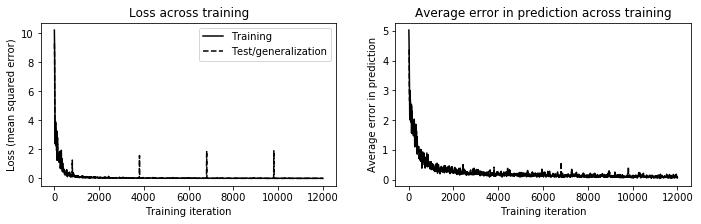

In [8]:
#@title Visualize results

fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)

# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (mean squared error)")
ax.legend()

# Correct.
y_tr = errors_tr
y_ge = errors_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Average error in prediction across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Average error in prediction")